# Anomaly Detection
In this project I'll be using autoencoders to detect anomalies on the [ECG5000 dataset](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000). This practice progject is taken from TensorFlow's tutorials on [Intro to Autoencoders](https://www.tensorflow.org/tutorials/generative/autoencoder#third_example_anomaly_detection).

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

## Load Dataset

In [25]:
df = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = df.values
df.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818287,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490658,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [26]:
labels = raw_data[:, -1]
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

### Preprocessing

In [27]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

In [28]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

### Plotting ECG

#### Normal ECG

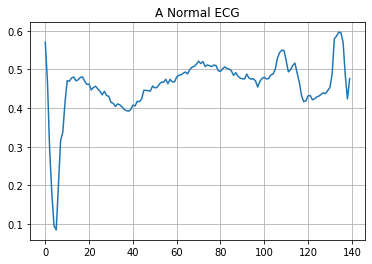

In [29]:
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("A Normal ECG")
plt.show()

#### Anomalous ECG

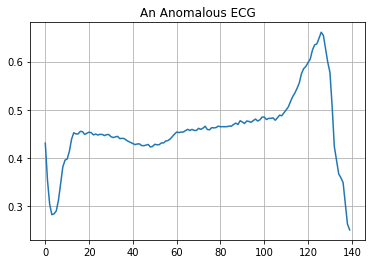

In [30]:
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("An Anomalous ECG")
plt.show()

## Model

In [35]:
class AnomalyDetector(Model):
    def __init__(self):
        super(AnomalyDetector, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Dense(32, activation='relu'),
            layers.Dense(16, activation='relu'),
            layers.Dense(8, activation='relu')
        ])
        
        self.decoder = tf.keras.Sequential([
            layers.Dense(16, activation='relu'),
            layers.Dense(32, activation='relu'),
            layers.Dense(140, activation='sigmoid')
        ])
    
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = AnomalyDetector()

## Optimizer

In [36]:
autoencoder.compile(optimizer='adam', loss='mae')

## Training

In [37]:
history = autoencoder.fit(normal_train_data, normal_train_data,
                         epochs=50,
                         batch_size=512,
                         validation_data=(test_data, test_data),
                         shuffle=True)

Epoch 1/50
5/5 [==============================] - 0s 12ms/step - loss: 0.0597 - val_loss: 0.0536
Epoch 2/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0567 - val_loss: 0.0524
Epoch 3/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0549 - val_loss: 0.0508
Epoch 4/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0521 - val_loss: 0.0496
Epoch 5/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0489 - val_loss: 0.0479
Epoch 6/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0453 - val_loss: 0.0457
Epoch 7/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0418 - val_loss: 0.0444
Epoch 8/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0384 - val_loss: 0.0426
Epoch 9/50
5/5 [==============================] - 0s 3ms/step - loss: 0.0352 - val_loss: 0.0415
Epoch 10/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0324 - val_loss: 0.0401
Epoch 11/50
5/5 [=====================

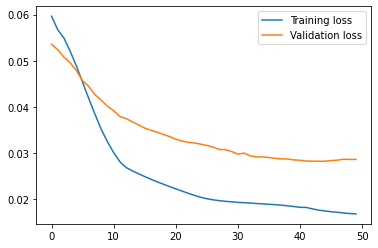

In [38]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label="Validation loss")
plt.legend()

## Testing

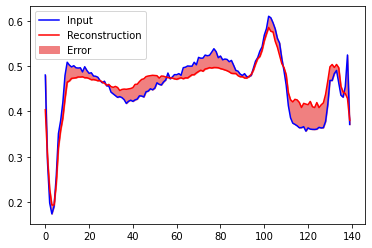

In [39]:
encoded_imgs = autoencoder.encoder(normal_test_data).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

plt.plot(normal_test_data[0],'b')
plt.plot(decoded_imgs[0],'r')
plt.fill_between(np.arange(140), decoded_imgs[0], normal_test_data[0], color='lightcoral' )
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

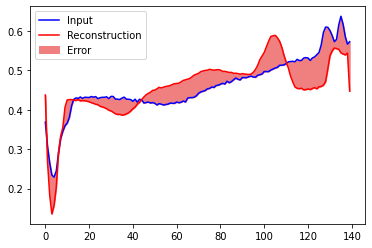

In [40]:
encoded_imgs = autoencoder.encoder(anomalous_test_data).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

plt.plot(anomalous_test_data[0],'b')
plt.plot(decoded_imgs[0],'r')
plt.fill_between(np.arange(140), decoded_imgs[0], anomalous_test_data[0], color='lightcoral' )
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()